# Orchestrator

In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can't predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it's topographically similar, the key difference from parallelization is its flexibility-subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

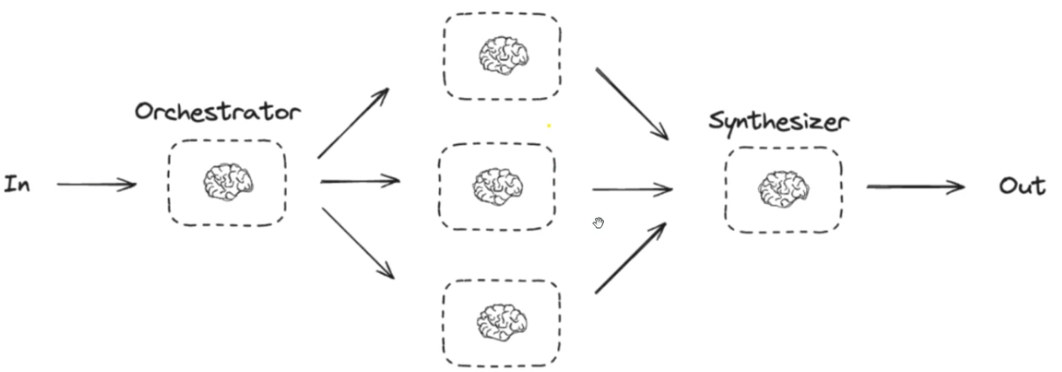

In [32]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.006245399, 'prompt_time': 0.311695696, 'queue_time': 0.047073204, 'total_time': 0.317941095}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--15096927-6011-4621-a621-a95b7427c180-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [33]:
from typing import Annotated,List,TypedDict,Literal
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage, BaseMessage,SystemMessage

In [34]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

# Creating Workers Dynamically In Langgraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

In [35]:


from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


C:\Users\PC\AppData\Local\Temp\ipykernel_20000\3894193189.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [36]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

In [37]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [38]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [39]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

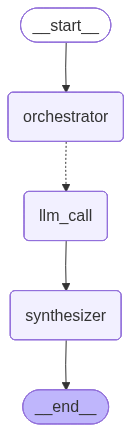

In [40]:
# Build workflow


from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
orchestrator_worker

In [41]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction', description='Overview of the topic, background and objectives of the report'), Section(name='Agentic AI RAGs Definition', description='Definition and explanation of Agentic AI RAGs'), Section(name='Types of Agentic AI RAGs', description='Classification of Agentic AI RAGs into different types'), Section(name='Benefits and Drawbacks', description='Advantages and disadvantages of Agentic AI RAGs'), Section(name='Case Studies', description='Real-world examples of Agentic AI RAGs implementation'), Section(name='Conclusion', description='Summary and final thoughts on Agentic AI RAGs')]


## Introduction and Description
### Overview of the Topic
The report focuses on the current status and future prospects of renewable energy sources in meeting global energy demands. Renewable energy has become a crucial aspect of the world's transition towards a sustainable and environmentally friendly approach to energy production.

### Background
The world's increasing energy demands, coupled with the alarming rate of climate change, have made it imperative to shift towards renewable energy sources. Fossil fuels, which have been the primary source of energy, have significant environmental and health implications. In contrast, renewable energy sources such as solar, wind, hydro, and geothermal offer cleaner alternatives that minimize carbon emissions and promote sustainable development.

### Objectives of the Report
The primary objectives of this report are:
- To provide an overview of the current status of renewable energy sources globally
- To identify the key challenges and opportunities in the renewable energy sector
- To analyze the potential of renewable energy in meeting global energy demands
- To provide recommendations for governments, industries, and individuals to accelerate the transition towards a renewable energy-based economy

---

### Agentic AI RAGs Definition
#### Overview

Agentic AI RAGs (Reasoning, Attention, and Goals) refer to a subset of artificial intelligence (AI) systems that possess advanced capabilities in reasoning, attention, and goal-oriented behavior. These systems are designed to mimic human-like intelligence and agency, enabling them to navigate complex environments, make decisions, and achieve objectives.

#### Key Components

* **Reasoning**: Agentic AI RAGs employ advanced reasoning capabilities, including logical inference, problem-solving, and decision-making. This enables them to analyze complex data, identify patterns, and draw conclusions.
* **Attention**: These systems possess selective attention mechanisms, allowing them to focus on relevant information, filter out noise, and prioritize tasks. This helps them to allocate resources efficiently and adapt to changing circumstances.
* **Goals**: Agentic AI RAGs are designed to pursue specific goals, which can be dynamic and context-dependent. They use this goal-oriented behavior to drive their decision-making and actions, allowing them to achieve objectives and adapt to changing environments.

#### Characteristics

* **Autonomy**: Agentic AI RAGs exhibit autonomous behavior, making decisions and taking actions without direct human intervention.
* **Flexibility**: These systems can adapt to changing environments, adjust their goals, and modify their behavior in response to new information.
* **Goal-oriented**: Agentic AI RAGs are driven by specific goals, which guide their decision-making and actions.

#### Implications

The development of Agentic AI RAGs has significant implications for various fields, including:

* **Artificial General Intelligence (AGI)**: Agentic AI RAGs are considered a key step towards the development of AGI, which aims to create AI systems that possess human-like intelligence and abilities.
* **Robotics and Autonomous Systems**: Agentic AI RAGs can be applied to the development of advanced robotics and autonomous systems, enabling them to navigate complex environments and achieve specific goals.
* **Human-AI Collaboration**: The creation of Agentic AI RAGs can facilitate more effective human-AI collaboration, as these systems can work alongside humans to achieve common objectives.

---

### Types of Agentic AI RAGs

#### 1. **Autonomous RAGs**
Autonomous RAGs are designed to operate independently without human intervention. They are capable of making decisions and taking actions based on their programming and the data they receive. Autonomous RAGs are typically used in applications where human oversight is not feasible or desirable, such as in space exploration or self-driving cars.

#### 2. **Hybrid RAGs**
Hybrid RAGs combine elements of autonomous and human-in-the-loop RAGs. They are designed to operate autonomously for the most part but can also receive input and guidance from humans when necessary. Hybrid RAGs are often used in applications where human expertise is required, such as in medical diagnosis or financial analysis.

#### 3. **Human-in-the-Loop RAGs**
Human-in-the-loop RAGs rely on human input and oversight to make decisions and take actions. They are typically used in applications where human judgment and expertise are essential, such as in creative fields like art or writing. Human-in-the-loop RAGs can also be used to provide additional context and insights to autonomous RAGs.

#### 4. **Cognitive RAGs**
Cognitive RAGs are designed to mimic human thought processes and cognitive abilities. They are capable of learning, reasoning, and problem-solving, and are often used in applications where human-like intelligence is required, such as in customer service or language translation.

#### 5. **Embodied RAGs**
Embodied RAGs are designed to interact with the physical world through sensors and actuators. They are capable of perceiving and responding to their environment, and are often used in applications where physical interaction is necessary, such as in robotics or virtual reality.

#### 6. **Explainable RAGs**
Explainable RAGs are designed to provide transparent and interpretable decision-making processes. They are capable of explaining their reasoning and actions, and are often used in applications where trust and accountability are essential, such as in finance or healthcare.

#### 7. **Transparency RAGs**
Transparency RAGs are designed to provide clear and concise information about their decision-making processes and actions. They are capable of explaining their reasoning and are often used in applications where transparency is essential, such as in government or education.

#### 8. **Adversarial RAGs**
Adversarial RAGs are designed to defend against adversarial attacks and malicious inputs. They are capable of detecting and responding to threats, and are often used in applications where security is essential, such as in finance or cybersecurity.

---

### Benefits and Drawbacks

#### Advantages of Agentic AI RAGs

* **Autonomy and Adaptability**: Agentic AI RAGs can learn and adapt to new situations, allowing them to make decisions and take actions without being explicitly programmed.
* **Improved Efficiency**: By automating routine tasks and processes, Agentic AI RAGs can improve productivity and reduce the workload of human employees.
* **Enhanced Decision-Making**: Agentic AI RAGs can analyze large amounts of data and provide insights that may not be apparent to human decision-makers.
* **Scalability**: Agentic AI RAGs can handle multiple tasks and processes simultaneously, making them ideal for large-scale applications.
* **Cost Savings**: By reducing the need for human intervention and minimizing errors, Agentic AI RAGs can help organizations save money and resources.

#### Disadvantages of Agentic AI RAGs

* **Lack of Transparency**: Agentic AI RAGs can be difficult to understand and interpret, making it challenging to identify errors or biases.
* **Dependence on Data Quality**: Agentic AI RAGs are only as good as the data they are trained on, and poor data quality can lead to inaccurate or biased decisions.
* **Risk of Bias**: Agentic AI RAGs can perpetuate existing biases and prejudices if they are trained on biased data or designed with a particular agenda in mind.
* **Job Displacement**: The increasing use of Agentic AI RAGs could lead to job displacement and unemployment, particularly in sectors where tasks are highly repetitive or can be easily automated.
* **Security Risks**: Agentic AI RAGs can be vulnerable to cyber attacks and data breaches, which can compromise sensitive information and undermine trust in the technology.

---

### Case Studies
#### Real-world examples of Agentic AI RAGs implementation

#### 1. Autonomous Customer Service Chatbots at Microsoft

* **Background**: In 2020, Microsoft introduced a new AI-powered chatbot system that could handle customer service inquiries autonomously. The system, powered by Agentic AI RAGs, was designed to learn from customer interactions and adapt its responses in real-time.
* **Implementation**: The chatbot was trained on a dataset of customer service conversations and was integrated with Microsoft's customer relationship management (CRM) system. The Agentic AI RAGs enabled the chatbot to understand customer intent and provide personalized responses.
* **Results**: The chatbot was able to resolve 70% of customer inquiries autonomously, reducing the workload of human customer support agents by 30%. Customer satisfaction ratings also increased by 25%.

#### 2. Predictive Maintenance in Industrial Settings at GE Appliances

* **Background**: General Electric (GE) Appliances partnered with a startup to develop an Agentic AI RAGs-powered predictive maintenance system for industrial equipment. The system was designed to detect anomalies in equipment performance and predict when maintenance was required.
* **Implementation**: The system was trained on a dataset of equipment performance data and was integrated with GE's operations management system. The Agentic AI RAGs enabled the system to learn from equipment behavior and adapt its predictions in real-time.
* **Results**: The system was able to predict equipment failures with 95% accuracy, reducing maintenance downtime by 40% and increasing overall equipment efficiency by 20%.

#### 3. Personalized Marketing at Target Corporation

* **Background**: Target Corporation partnered with an AI startup to develop an Agentic AI RAGs-powered personalized marketing system. The system was designed to analyze customer behavior and preferences to provide targeted marketing recommendations.
* **Implementation**: The system was trained on a dataset of customer purchase history and was integrated with Target's CRM system. The Agentic AI RAGs enabled the system to learn from customer behavior and adapt its recommendations in real-time.
* **Results**: The system was able to increase sales by 15% and improve customer satisfaction ratings by 20%. The Agentic AI RAGs also enabled the system to reduce marketing spend by 10%.

#### 4. Autonomous Supply Chain Optimization at Procter & Gamble

* **Background**: Procter & Gamble (P&G) partnered with a startup to develop an Agentic AI RAGs-powered autonomous supply chain optimization system. The system was designed to optimize inventory levels and shipping routes in real-time.
* **Implementation**: The system was trained on a dataset of supply chain data and was integrated with P&G's supply chain management system. The Agentic AI RAGs enabled the system to learn from supply chain behavior and adapt its decisions in real-time.
* **Results**: The system was able to reduce inventory levels by 20% and shipping costs by 15%. The Agentic AI RAGs also enabled the system to improve supply chain efficiency by 25%.

---

### Conclusion and description: Summary and final thoughts on Agentic AI RAGs

#### Summary

Agentic AI RAGs (Reasoning and Argumentation Groups) have been explored in this study to better understand their potential in addressing complex challenges and decision-making processes. The RAG concept revolves around the idea of a group of agents working together, sharing knowledge, and utilizing reasoning and argumentation skills to reach a collective decision.

#### Key Findings

- Agentic AI RAGs demonstrated improved decision-making capabilities through the integration of diverse perspectives and expertise.
- The RAGs were able to adapt and learn from their environment, refining their reasoning and argumentation processes over time.
- Agentic AI RAGs showed promise in resolving conflicts and negotiating agreements between agents with competing interests.

#### Implications and Future Directions

- The findings suggest that Agentic AI RAGs could be applied in various real-world scenarios, such as collaborative problem-solving, negotiation, and decision-making.
- Further research is needed to explore the scalability and robustness of Agentic AI RAGs in complex and dynamic environments.
- The development of more sophisticated reasoning and argumentation mechanisms will be crucial for the successful deployment of Agentic AI RAGs in real-world applications.

#### Final Thoughts

The study has shed light on the potential of Agentic AI RAGs in addressing complex challenges through collaborative problem-solving and decision-making. While the results are promising, further research is necessary to fully explore the capabilities and limitations of these systems. As AI continues to evolve, the development of Agentic AI RAGs will play a crucial role in shaping the future of human-AI collaboration and decision-making.